In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm
from matplotlib import colors

In [19]:
plt.rcParams["figure.figsize"] = [15.00, 7.50]
plt.rcParams["figure.autolayout"] = True
#plt.rcParams["figure.figsize"] = [30.00, 20.50]
#plt.rcParams["figure.autolayout"] = True

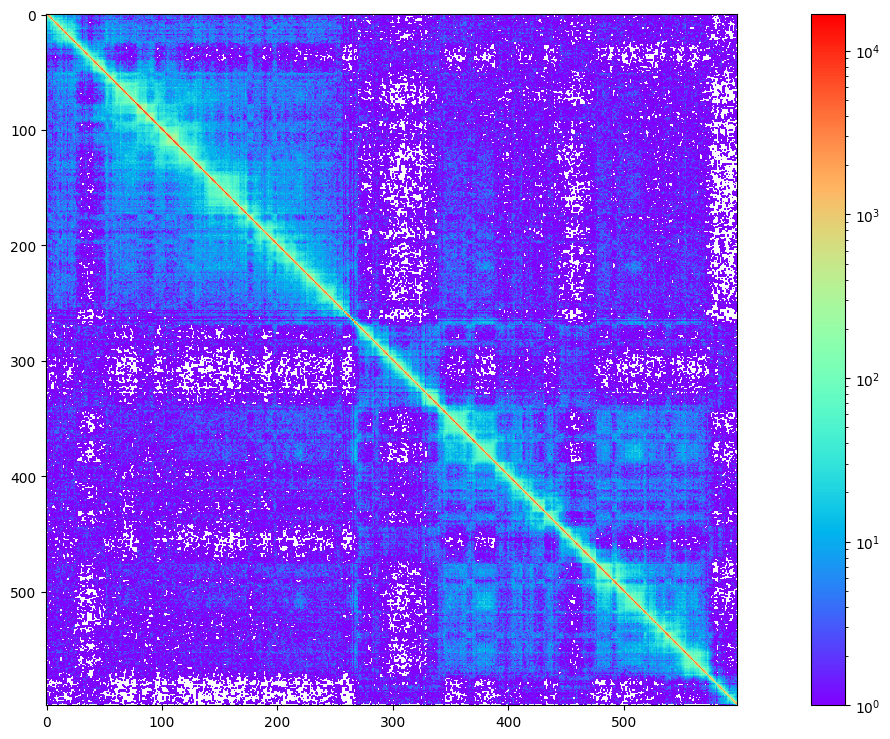

C shape (599, 599)


In [20]:
path = '..//data//IMR90_100kb_chr20.csv'
C = np.array(pd.read_csv(f'{path}', header=None))

def plot_C(C):
    im = plt.imshow(C, cmap=cm.rainbow, norm=colors.LogNorm())
    plt.colorbar(im)
    plt.show()

mask = (C == 0).all(0)
# Find the indices of these columns
index = np.where(~mask)[0]
C = C[~mask,:]
C = C[:,~mask]


plot_C(C)

print('C shape', C.shape)

In [3]:
def extract_block_diag(A,M,k=0):
    """Extracts blocks of size M from the kth diagonal 
    of square matrix A, whose size must be a multiple of M.
    
    (k=0 - the main diagnoal)
    
    """

    # Check that the matrix can be block divided. If it is not, cut the matrix into 2 blocks such that the first block is divided into M blocks and the last one remains as it is
    rem_ = None
    if A.shape[0] != A.shape[1] or A.shape[0] % M != 0:
        rem_ = []
        remainder_block = A[-(A.shape[0] % M):, -(A.shape[0] % M):]   
        rem_.append([remainder_block, [A.shape[0]-(A.shape[0] % M), A.shape[0]-(A.shape[0] % M)], [A.shape[0], A.shape[0]]])

        A = A[:-(A.shape[0] % M), :-(A.shape[0] % M)]

    # Assign indices for offset from main diagonal
    if abs(k) > M - 1:
        raise ValueError('kth diagonal does not exist in matrix')
    elif k > 0:
        ro = 0
        co = abs(k)*M 
    elif k < 0:
        ro = abs(k)*M
        co = 0
    else:
        ro = 0
        co = 0
    def get_block(A, i, ro, M, co):
        c1_left_x = i+ro
        c1_left_y = i+co

        c2_right_x = i+ro+M
        c2_right_y = i+co+M
        return [A[i+ro:i+ro+M,i+co:i+co+M], [c1_left_x,  c1_left_y], [c2_right_x, c2_right_y]]
    blocks = [get_block(A, i, ro, M, co)
                       for i in range(0,len(A)-abs(k)*M,M)]
    if rem_ is not None:
        blocks.extend(rem_)
    return blocks

### 

In [4]:
# visual test

#print('np.diag', [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, C.shape[0])][:5])
#print('----')
#print('extract block', extract_block_diag(C, 1)[:5])
#print('\n----reverse----\n')
#print('np.diag', [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, C.shape[0])][-5:])
#print('----')
#print('extract block', extract_block_diag(C, 1)[-5:])

In [5]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def merge_clusters(C, clusters, i1, i2):
    '''
    Input:
    C: contact matrix (np.array)
    clusters: list of currents clusters
    i1: index representing i1-th cluster in 'clusters'
    i2: index representing i2-th cluster in 'clusters'
    Output:
    A list of length 3, where:
    the 1st element is the resulting cluster (block); dtype = np.array
    the 2d element is the upper left coordinate of the block; dtype = (x, y)
    the 3d element is the lower right coordinate of the block; dtype = (x, y)
    '''
    assert i2 - i1 == 1
    c1 = clusters[i1]
    c2 = clusters[i2]

    c1_left_x = c1[1][0]
    c1_left_y = c1[1][1]
    c2_right_x = c2[2][0]
    c2_right_y = c2[2][1]
    return [C[c1_left_x:c2_right_x, c1_left_y:c2_right_y], [c1_left_x,  c1_left_y], [c2_right_x, c2_right_y]] # [C[c1_left_x:c2_right_x+1, c1_left_y:c2_right_y+1], [c1_left_x,  c1_left_y], [c2_right_x+1, c2_right_y+1]]

def get_cluster(u, u_t, C, clusters):
    if u < u_t:
        return clusters[u]
    if u == u_t:
        return merge_clusters(C, clusters, u, u+1)
    if u > u_t:
        return clusters[u+1]
def clusterize(C, depth, initial_cluster_size, measure, criterion,  color_norm):
    C = C.copy()
    np.fill_diagonal(C, 0)
    clusters = []
    clusters = extract_block_diag(C, initial_cluster_size) # alternative, but not recommended: [[np.diag(C)[i], [i, i], [i, i]] for i in range(0, p)]
    p = len(clusters)
    print('initial depth:')
    for t in range(0, p):
        u_t = criterion([measure(
        clusters,
        merge_clusters(C, clusters, u, u+1),
        clusters[u],
        clusters[u+1]) for u in range(0, p - t - 1)])
        clusters = [get_cluster(u, u_t, C, clusters) for u in range(0, p-t-1)]
        if len(clusters) == depth:
            break
    
    
    # Plotting

    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(C, cmap=cm.rainbow, norm = color_norm)

    for cluster in clusters:
        rect = patches.Rectangle(cluster[1], cluster[2][0]-cluster[1][0], cluster[2][1]-cluster[1][0], linewidth=6, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()
    return clusters

In [6]:
def scale(y, center=True, scale=True):
    x = y.copy()
    if center:
        x -= x.mean(axis=0)
    if scale and center:
        x /= x.std()
    #elif scale:
    #    x /= np.sqrt(x.pow(2).sum().div(x.count() - 1))
    return x

/var/folders/1h/vdwncgy92617gdzwjj6km11c0000gn/T/ipykernel_65499/1962694932.py:19: RuntimeWarning: divide by zero encountered in divide
  inverse_C = 1/C


initial depth:


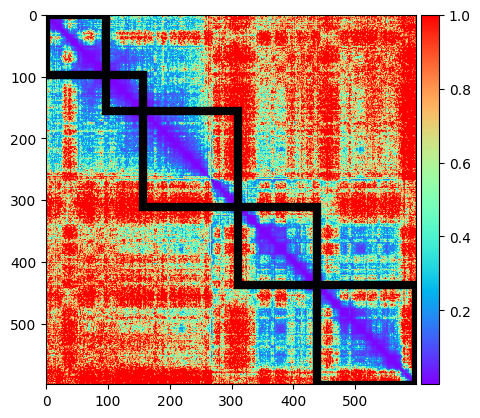

In [7]:
#def measure(cluseters, merged_clusters, c1, c2):
#    return -(np.mean(merged_clusters[0]) - np.mean(c1[0]) - np.mean(c2[0]))
#def measure(merged_clusters, c1, c2):
#   return np.sum(merged_clusters[0]) / (merged_clusters[0].size - merged_clusters[0].shape[0]) - np.sum(c1[0]) / (c1[0].size - c1[0].shape[0]) - np.sum(c2[0]) / (c2.size[0] -c2[0].shape[0])
#for lambd in [1, 1/2, 1/4, 1/8, 1/16, 1/128, 1/1024, 0.00000000005]:
m = 599
inverse = True
depth = 5
use_log = True
initial_cluster_size = 1

def value_function(cluster, size_coeff=1, estimator = np.sum):
    return estimator(cluster) - size_coeff*(cluster.size)

if inverse:
    def measure(clusters, merged_clusters, c1, c2, value_function=value_function):
        min_size = min([cluster[0].size for cluster in clusters])
        return -(value_function(merged_clusters[0]) - value_function(c1[0]) - value_function(c2[0]))#+ merged_clusters[0].size
    inverse_C = 1/C
    inverse_C[inverse_C == np.inf] = 1
    #inverse_C = scale(inverse_C, center = True, scale = False)
    clusters = clusterize(inverse_C [:m, :m], 
            depth = depth,
            initial_cluster_size = initial_cluster_size,
            measure = measure,
            criterion = np.argmin,
            color_norm= colors.Normalize(inverse_C.min(), inverse_C.max()))
else:
    def measure(clusters, merged_clusters, c1, c2):
        min_size = max([cluster[0].size for cluster in clusters])
        return (np.mean(merged_clusters[0]) - np.mean(c1[0]) - np.mean(c2[0])) - 2*merged_clusters[0].size/min_size
    if use_log:
        log_data = np.log(C)
        log_data[log_data == -np.inf] = 0.0
        clusters = clusterize(log_data[:m, :m], 
                depth = depth,
                initial_cluster_size = initial_cluster_size,
                measure = measure,
                criterion = np.argmax,
                color_norm= colors.LogNorm())
    else:
        clusters = clusterize(C[:m, :m], 
                depth = depth,
                initial_cluster_size = initial_cluster_size,
                measure = measure,
                criterion = np.argmax,
                color_norm= colors.LogNorm())



# Srinkage Clustering Implementation

In [3]:
import numpy as np

In [4]:
def shrinkage_clustering(S, k, num_iter = 100):
    n = S.shape[0]
    assert n >= k
    ## generate random A(n x k) matrix. check that no zero columns are generated
    A = np.stack([np.random.permutation(np.eye(k, 1)).T for _ in range(n)]).reshape((n, k))
    while np.any(A.sum(axis = 0) == 0) == True:
        A = np.stack([np.random.permutation(np.eye(k, 1)).T for _ in range(n)]).reshape((n, k))
    v = np.ones(S.shape[0])

    for _ in range(num_iter):
        A = A[:, ~np.all(A == 0, axis=0)]
        
        if sum(v) == 0:
            break
        
        ## remove zero columns
        
        #mask = A == 0
        #cols = np.flatnonzero((~mask).sum(axis=0))
        #A = A[:, cols.min():cols.max()+1]

        ## permute the cluster membership

        M = (1 - 2 * S ) @ A
        #return M, A
        v = np.min(M, axis = 1) - np.sum(M * A, axis = 1)
        #print(v)
        X_ = np.argmin(v)
        #print('M', M[X_, :])
        C_prime = np.argmin(M[X_, :])

        A[X_, :] = 0
        A[X_, C_prime] = 1

    return A

In [5]:

S = np.array([
    [1., 0.1, 0.9, 0.],
    [0.1, 1., 0., 0.],
    [0.9, 0., 1., 0.99],
    [0., 0., 0.99, 1.]
])
S = np.array([
    [1., 1, 0.],
    [1, 1.0, 0.0],
    [0.0, 0.0, 1.]
])
A = shrinkage_clustering(S, 3)
A
#n = A.shape[0]
#k = A.shape[1]
#V = M - np.repeat((M*A).sum(1)[:, np.newaxis], k, 1)
#v = np.min(V, axis = 1)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [6]:
import torch 
from torch import nn

In [216]:
def getMaskMat(A):
    AX = np.zeros_like(A)
    left = np.where(A[:, 0])[0]
    right = np.where(A[:, -1])[0]
    AX[left, 0] = 0
    AX[left, 1] = 1

    AX[right, -1] = 0
    AX[right, -2] = 1

    interm_rows = A[~np.isin(np.arange(A.shape[0]), np.append(left, right))]

    interm_rows = np.roll(interm_rows, -1) + np.roll(interm_rows, 1)
    AX[np.where(~np.isin(np.arange(A.shape[0]), np.append(left, right)))[0]] = interm_rows
    return AX

(3, 3)

In [222]:
V_masked.shape

(3, 2)

In [217]:
def h_shrinkage_clustering(S, k, num_iter = 100):
    n = S.shape[0]
    assert n >= k
    ## generate random A(n x k) matrix. check that no zero columns are generated
    A = np.stack([np.random.permutation(np.eye(k, 1)).T for _ in range(n)]).reshape((n, k))
    while np.any(A.sum(axis = 0) == 0) == True:
        A = np.stack([np.random.permutation(np.eye(k, 1)).T for _ in range(n)]).reshape((n, k))
    v = np.ones(S.shape[0])

    for _ in range(num_iter):

        A = A[:, ~np.all(A == 0, axis=0)]
        
        if sum(v) == 0:
            break
        
        ## remove zero columns
        mask = A == 0
        cols = np.flatnonzero((~mask).sum(axis=0))
        A = A[:, cols.min():cols.max()+1]

        ## permute the cluster membership

        M = (1 - 2 * S ) @ A
        V = M - np.repeat((M*A).sum(1)[:, np.newaxis], A.shape[1], 1)
        mask = getMaskMat(A)
        V_masked = V * mask
        return V_masked, mask, A
        v = np.min(V_masked, axis = 1)
        X_ = np.argmin(v)
        C_prime = np.argmin(M[X_, :])

        A[X_, :] = 0
        A[X_, C_prime] = 1


    return A

In [218]:


S = np.array([
    [1., 0., 0.],
    [0., 1.0, 0.0],
    [0., 0.0, 1.]
])
S = np.array([
    [1., 0, 1., 0.],
    [0, 1., 0., 0.],
    [1., 0., 1., 0.99],
    [0., 0., 0.99, 1.]
])
S = np.array([
    [1., 1, 0.],
    [1, 1.0, 0.0],
    [0.0, 0.0, 1.]
])
S = np.array([
    [1., 0., 1.],
    [0., 1.0, 0.0],
    [1.0, 0.0, 1.]
])

v_aux = h_shrinkage_clustering(S, S.shape[0]) #V, V_masked, mask, M, 

In [219]:
v_aux

(array([[0., 0., 2.],
        [0., 2., 0.],
        [0., 0., 0.]]),
 array([[1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]]),
 array([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]]))

In [181]:
v_aux

array([2.005, 2.005, 2.005])

In [123]:
S = np.array([
    [1., 0, 1., 0.],
    [0, 1., 0., 0.],
    [1., 0., 1., 0.99],
    [0., 0., 0.99, 1.]
])

A = h_shrinkage_clustering(S, S.shape[0]) #V, V_masked, mask, M, 
A

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [132]:
S = np.array([
    [1., 0.5, 1., 0.],
    [0.5, 1., 0., 0.],
    [1., 0., 1., 0.99],
    [0., 0., 0.99, 1.]
])

A = h_shrinkage_clustering(S, 3) #V, V_masked, mask, M, 
A

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [519]:
import numpy as np 
from math import sqrt, isclose
from random import randint, shuffle
import matplotlib.pyplot as plt     
import matplotlib.animation as animation             


def euclidean_distance(x, y): 
    """
    Takes two coordinates as input, returns the euclidean distance between them. 
    param x: A pair (x, y). 
    param y: A pair (x, y).
    """
    x1, y1 = x
    x2, y2 = y
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)


def random_cluster_matrix(shape): 
    """
    Creates an (N, M) matrix where a random cell in each row is 1, otherwise 0.
    param shape: A pair (N, M).
    """
    N, k = shape
    A = np.zeros((N, k))
    for row in A: 
        row[randint(0, k - 1)] = 1

    return A


def remove_clusters(A, cluster_indeces): 
    """
    Removes the clusters (i.e. columns given by the indices) from a matrix A. 
    """
    return np.delete(A, cluster_indeces, axis=1)


def progress(current, max): 
    """
    Prints a progress bar given the current number of steps and the maximum/goal 
    number of steps.
    """
    prog = int(20 * (current / max))
    print(f"[{''.join('=' for _ in range(prog))}>{''.join(' ' for _ in range(20 - prog - 1))}] ({(current / max) * 100 : 2.2f}%)", end='\r')


def plot(points, A, k): 
    colors = ['r', 'g', 'b', 'k', 'm', 'y', 'black', 'purple', 'pink', 'azure']
    plt.clf()
    
    for cluster in range(k): 
        point_idxs = np.argwhere(A.T[cluster])
        pts = [(x,y) for i, (x,y) in enumerate(points) if i in point_idxs]
        if pts:
            xs, ys = zip(*pts)
            plt.plot(xs, ys, 'bo', color=colors[cluster])
        
    plt.pause(0.0001)

def cluster(S, k=None, max_iter=100, visualize=False, points=None): 
    """
    Uses Shrinkage clustering to provide a cluster assignments matrix given a 
    similarity matrix S. 
    param S: Similarity matrix for all points to be clustered. 
    param k: Initial number of clusters. Will be reduced as the algorithm runs, 
             so start high.
    """
    N = len(S)
    if not k: 
        k = N

    S_bar = 1 - 2 * S
    A = random_cluster_matrix((N, k))

    if visualize:
        if not points: 
            raise ValueError("Cannot visualize clustering without points.")
        plt.ion()
    
    for _i in range(max_iter): 
        #print("HUI")
        # Remove empty clusters
        empty_columns = [i for i in range(k) if sum(A[:,i]) == 0]
        A = remove_clusters(A, empty_columns)
        k = len(A[0])  # Adjust number of clusters

        # Permute cluster membership that minimizes objective the most:
        # (a) Compute M = ~SA
        M = S_bar @ A

        # (b) Compute v
        MoA = M * A
        v = [min(M[i]) - sum(MoA[i]) for i in range(N)]

        # Check if we converged
        if isclose(sum(v), 0, abs_tol=1e-5): 
            break

        # (c) Find the object X with the greatest optimization potential
        X = np.argmin(v)

        # (d) Reassign X to the cluster C where C = argmin(M[X][j]) w.r.t. j
        C = np.argmin(M[X])
        A[X] = np.zeros((k))
        A[X][C] = 1
        
        if _i % 10 == 0: 
            progress(_i, max_iter)
        
        if visualize: 
            plot(points, A, k)        

    return A


def square(S):
    """
    Converts a triangular matrix into a full square matrix. 
    Example: 
    [
        [0  0  0  0]       [0  3  2  4]
        [3  0  0  0]  -->  [3  0  3  1]
        [2  3  0  0]       [2  3  0  5]
        [4  1  5  0]       [4  1  5  0]
    ]
    """
    full = S.T + S
    idx = np.arange(S.shape[0])
    full[idx,idx] = S[idx,idx]
    return full 


def read_points(from_file): 
    """
    Reads and returns a list of points [(x,y), ...] from a file.
    """
    points = []
    with open(from_file) as fp: 
        for line in fp.readlines(): 
            feats = line.strip().split()
            points.append((int(feats[0]), int(feats[1])))

    return points


def similarity_matrix(P, similarity_measure, normalize=True, inverse=True):
    """
    Builds a similarity matrix over a set of elements
    using the provided similarity measure. 
    
    param P: List of data points. 
    param similarity_measure: Binary function for determining 
                              the similariy between two points.
    param normalize: Normalize all points in the matrix to [1,0]
    param inverse: Invert the values in the (normalized) matrix, 
                   i.e. returns 1 - M.
    """
    N = len(P) 
    S = np.zeros((N, N))
    for i in range(N): 
        for j in range(i): 
            S[i][j] = similarity_measure(P[i], P[j])

    S = square(S)
    if normalize: 
        S = S / np.max(S)
    if inverse:
        S = 1 - S  # Higher value = more similar

    return S


def cluster_shrinkage_clustering(from_file): 
    """
    Wrapper for cluster() that outputs data as 
    (xs, ys, labels) so it can be fed easily to a 
    matplotlib scatterplot.
    """
    points = read_points(from_file)
    shuffle(points)
    S = similarity_matrix(points, similarity_measure=euclidean_distance)
    A = cluster(S, k=10, max_iter=1000)
    labels = [np.argmax(p) for p in A]
    xs, ys = zip(*points)
    
    return xs, ys, labels

def demo(): 
    print(f'Reading...')
    points = read_points('data/clusters')
    shuffle(points)
    print(f'Calculating similarity matrix...')
    S = similarity_matrix(points, similarity_measure=euclidean_distance)
    print(f'Clustering...')
    A = cluster(S, k=10, max_iter=1000)

    # Visualise
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    labels = [np.argmax(p) for p in A]
    xs, ys = zip(*points)
    ax.scatter(xs, ys, c=labels)
    plt.show()

In [523]:
S = np.array([
    [1., 1, 0.],
    [1, 1.0, 0.0],
    [0.0, 0.0, 1.]
])
cluster(S)

array([[1.],
       [1.],
       [1.]])